<a href="https://colab.research.google.com/github/merrecalde/curso_la_plata_2019/blob/master/representacion_documentos_2da_parte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: representacion_documentos_2da_parte.ipynb

En esta notebook se utilizan distintos modelos de representación de documentos con distintas colecciones de datos que son cargadas de diversas formas: 

1. [20 News Group](https://colab.research.google.com/drive/12kMXEMrx7yPMaDq-ehq-1B5d8nsc73nE#scrollTo=HfAifJPQ66Vy)

En este caso se utiliza la colección *20 News Group*, cargándola mediante la facilidad "fetch_20newsgroups" provista por sci-kit learn. En este caso, además de la representación tf-idf clásica, se muestran dos ejemplos de reducción de dimensionalidad, uno mediante *selección de características* ($\chi^2$) y el otro mediante *transformación de características* (LSA)

2. [Colección oficialistas-opositores](#seccion2)

Esta es una colección en español con documentos periodísticos argentinos. Para su análisis se utilizan dos representaciones de documentos. Una con características "estáticas" obtenidas de LIWC y otra con características dinámicas obtenidas con los vectorizadores de scikit-learn

3. [Críticas de películas](#seccion3)

Opiniones sobre películas obtenidas de NLTK

4. [Transcripciones de monólogos](#seccion4)

Esta colección se obtiene de las transcripciones de monólogos de 12 artistas de stand-up bajados directamente de la Web.






<img src="https://images.freeimages.com/images/small-previews/c8e/books-1478715.jpg" alt="drawing" width="350"/> 
<img src="https://image.shutterstock.com/image-vector/shopping-bag-word-cloud-600w-137359802.jpg" alt="drawing" width="350"/>


<a id='section2'></a>
#1) 20 News Group

### Simulamos con el diccionario "opts" las distintas opciones que se pueden especificar respecto al número de categorías, filtrado de encabezados, uso de técnicas de reducción de dimensionalidad y número de features seleccionadas (o transformadas)

In [0]:
opts = {"all_categories" : False,
        "filtered" : True,
        "select_chi2" : True,
        "transform_LSA": True
        }

if opts.get("select_chi2"):
  opts["num_feat"] = 1000
  
if opts.get("transform_LSA"):
  opts["num_feat2"] = 50  

In [2]:
print(opts.keys())
opts.get("all_categories")

dict_keys(['all_categories', 'filtered', 'select_chi2', 'transform_LSA', 'num_feat', 'num_feat2'])


False

In [0]:
import logging
import numpy as np
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.pipeline import Pipeline


In [4]:
# #############################################################################
# Load some categories from the training set
if opts.get("all_categories"):
    categories = None
else:
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]
print(categories)

['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


In [5]:
if opts.get("filtered"):
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()

print(remove)    

('headers', 'footers', 'quotes')


In [6]:
print("Cargando la colección 20 newsgroups (subconjunto de entrenamiento) para las categorías:")
print(categories if categories else "all")

datos = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)
print('datos cargados \n \n ')
print("El objeto retornado por la operación de carga es de tipo:", type(datos))

# order of labels in `target_names` can be different from `categories`
target_names = datos.target_names


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


datos_size_mb = size_mb(datos.data)

print("%d documentos - %0.3fMB (en el conjunto cargado)" % (
    len(datos.data), datos_size_mb))
print("%d categorías" % len(target_names))
print()


Cargando la colección 20 newsgroups (subconjunto de entrenamiento) para las categorías:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
datos cargados 
 
 
El objeto retornado por la operación de carga es de tipo: <class 'sklearn.utils.Bunch'>
2034 documentos - 2.428MB (en el conjunto cargado)
4 categorías



In [7]:
y = datos.target

print("Extrayendo las características de los datos cargados usando un vectorizador sparse")
t0 = time()

vectorizador = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X = vectorizador.fit_transform(datos.data)
duration = time() - t0
print("realizado en %fs a %0.3fMB/s" % (duration, datos_size_mb / duration))
print("n_muestras: %d, n_features: %d" % X.shape)
print()

# mapping desde las features enteras al string del token original 
feature_names = vectorizador.get_feature_names()


Extrayendo las características de los datos cargados usando un vectorizador sparse
realizado en 0.353758s a 6.863MB/s
n_muestras: 2034, n_features: 26576



In [8]:
print("Tipo de los datos vectorizados (Matriz X): ", type(X))
print("Tipo del arreglo target (vector y): ", type(y))
print("... y los tamaños de X e y")
print(X.shape)
print(y.shape)

Tipo de los datos vectorizados (Matriz X):  <class 'scipy.sparse.csr.csr_matrix'>
Tipo del arreglo target (vector y):  <class 'numpy.ndarray'>
... y los tamaños de X e y
(2034, 26576)
(2034,)


##1.1) Selección de características (test $\chi^2$)




In [9]:
# Selección de características

if opts.get("select_chi2"):
    print("Extrayendo las %d mejores features por un test chi-squared" %
          opts.get("num_feat"))
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.get("num_feat"))
    X_chi2 = ch2.fit_transform(X, y)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################


Extrayendo las 1000 mejores features por un test chi-squared
done in 0.020940s



In [10]:
print("100 primeras features seleccionadas (ordenadas alfabéticamente)", feature_names[:100])
print("\n")
print("El tamaño de los datos reducidos (con las columnas seleccionadas):", X_chi2.shape)



100 primeras features seleccionadas (ordenadas alfabéticamente) ['18084tm' '1993' '1999' '2178' '23' '24' '24x' '256' '2d' '30' '32' '336'
 '355' '386' '3d' '3do' '3ds' '42' '486' '5000' '517' '640x480' '666'
 '68070' '713' '9591' 'abortion' 'absolute' 'accept' 'acm' 'act' 'action'
 'actions' 'acts' 'address' 'adobe' 'advance' 'advertising' 'aerospace'
 'agency' 'agent' 'agents' 'agree' 'agreed' 'air' 'aircraft' 'alaska'
 'alexia' 'algorithm' 'algorithms' 'alive' 'allah' 'allen' 'alt'
 'alternative' 'altitude' 'ames' 'amiga' 'amorc' 'amounts' 'angels'
 'animal' 'animals' 'animated' 'animation' 'animations' 'answered'
 'antenna' 'anti' 'anybody' 'apollo' 'apparent' 'appreciated' 'april'
 'archie' 'area' 'argue' 'arguing' 'argument' 'arguments' 'ascii' 'assert'
 'asteroids' 'astro' 'astronaut' 'astronomical' 'astronomy' 'atheism'
 'atheist' 'atheists' 'ati' 'atmosphere' 'author' 'authority' 'available'
 'away' 'bake' 'balloon' 'balls' 'barney']


El tamaño de los datos reducidos (con las

### Graficando las features de mayor $\chi^2$



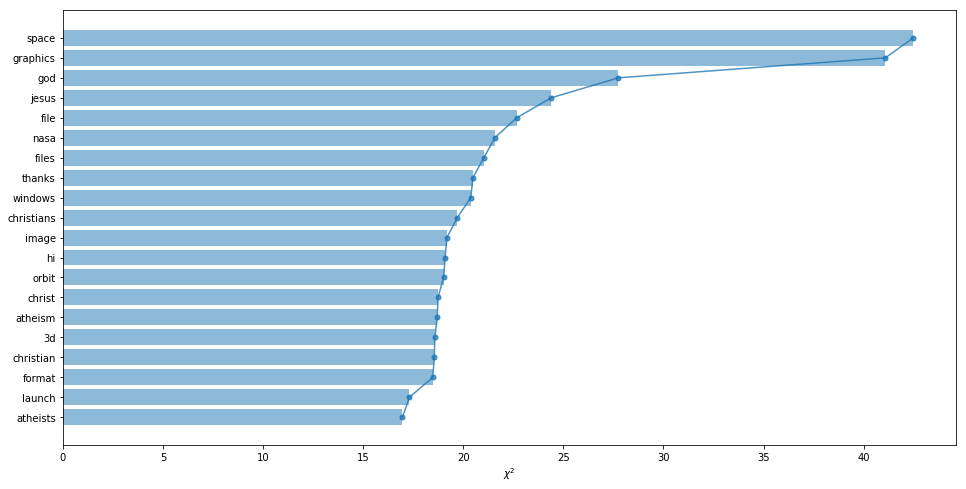

In [11]:
chi2score = chi2(X, y)[0]
plt.figure(figsize=(16,8))
scores = list(zip(vectorizador.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

##1.2) Transformación de características (LSA)

In [12]:
vectorizador2 = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
X2 = vectorizador2.fit_transform(datos.data)

print("hecho en %fs" % (time() - t0))
print("n_muestras: %d, n_features: %d" % X.shape)
print()

if opts.get("transform_LSA"):
    print("Realizando reducción de la dimensionalidad con LSA")
    t0 = time()
    # Los resultados del Vectorizer están normalizados. Dado que los resultados de LSA/SVD 
    # no son normalizados, rehacemos la normalización.
    svd = TruncatedSVD(opts.get("num_feat2"))
    normalizer = Normalizer(copy=False) #El normalizador es opcional
    lsa = make_pipeline(svd, normalizer)

    X_lsa = lsa.fit_transform(X2)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

print("El tamaño de los datos reducidos (con las columnas transformadas):\n", X_lsa.shape)
print("n_muestras: %d, n_features: %d" % X_lsa.shape)

hecho en 1.031878s
n_muestras: 2034, n_features: 26576

Realizando reducción de la dimensionalidad con LSA
done in 0.330681s
Explained variance of the SVD step: 11%

El tamaño de los datos reducidos (con las columnas transformadas):
 (2034, 50)
n_muestras: 2034, n_features: 50


#2) Colección *oficialistas* y *opositores*

Esta colección de documentos se describe [aqui], y consiste en 196 textos periodísticos escritos en el período de gobierno 201-2015, siendo la mitad de periodistas que adherian a las políticas del gobierno de aquellos años (oficialistas) y la otra mitad de periodistas opositores a dichas políticas. En este caso, se comienza primero con una representación con 90 features estáticas obtenidas mediante el sistema LIWC. Dicho datos se leen de un archivo en formato "csv" accesible en Github. La misma colección es accedida cargando los textos "crudos", desde un  directorio disponible en Google Drive. En este caso se monta el directorio donde se encuentra la colección de documentos y se cargan los documentos "crudos" con la facilidad *load_files* de sci-kit learn. 

 


## 2.1) Features estáticas (LIWC)

In [0]:
import pandas as pd

In [14]:
!wget "https://raw.githubusercontent.com/merrecalde/curso_la_plata_2019/master/oficialistas_LIWC.csv"
!wget "https://raw.githubusercontent.com/merrecalde/curso_la_plata_2019/master/opositores_LIWC.csv"
!wget "https://raw.githubusercontent.com/merrecalde/curso_la_plata_2019/master/ofi_opo_LIWC.csv"

--2019-09-25 23:30:22--  https://raw.githubusercontent.com/merrecalde/curso_la_plata_2019/master/oficialistas_LIWC.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64238 (63K) [text/plain]
Saving to: ‘oficialistas_LIWC.csv.1’

oficialistas_LIWC.c 100%[===================>]  62.73K  --.-KB/s    in 0.01s   

2019-09-25 23:30:22 (4.26 MB/s) - ‘oficialistas_LIWC.csv.1’ saved [64238/64238]

--2019-09-25 23:30:24--  https://raw.githubusercontent.com/merrecalde/curso_la_plata_2019/master/opositores_LIWC.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 

In [0]:
data_ofi = pd.read_csv('oficialistas_LIWC.csv',decimal=',')
data_opo = pd.read_csv('opositores_LIWC.csv',decimal=',')
data_ofi_opo = pd.read_csv('ofi_opo_LIWC.csv',decimal=',')

### Número de palabras (opositor)

In [16]:
data_opo.head()

,Filename,Segment,WC,WPS,Sixltr,Dic,Funct,TotPron,PronPer,Yo,Nosotro,TuUtd,ElElla,Ellos,PronImp,Articulo,Verbos,VerbAux,Pasado,Present,Futuro,Adverb,Prepos,Conjunc,Negacio,Cuantif,Numeros,Maldec,verbYO,verbTU,verbNOS,verbosEL,verbELLOS,Subjuntiv,VosUtds,formal,informal,verbVos,Social,Familia,...,Tentat,Certeza,Inhib,Incl,Excl,Percept,Ver,Oir,Sentir,Biolog,Cuerpo,Salud,Sexual,Ingerir,Relativ,Movim,Espacio,Tiempo,Trabajo,Logro,Placer,Hogar,Dinero,Relig,Muerte,Asentir,NoFluen,Relleno,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,al01.txt,1,1156,23.59,23.53,68.86,46.11,13.15,8.48,0.09,0.00,0.17,8.30,3.37,4.67,12.37,8.48,0.26,2.51,4.67,0.0,3.03,15.05,6.57,1.56,0.95,1.38,0.0,0.43,0.17,0.00,2.16,0.87,0.95,0.17,0.00,0.00,0.0,8.74,0.52,...,1.47,1.56,0.35,6.57,1.47,1.90,0.35,0.26,0.61,1.82,0.78,0.26,0.26,0.87,7.09,2.08,3.37,2.34,2.51,1.30,1.04,0.43,1.04,0.61,0.61,0.35,0.0,0.0,8.91,4.15,3.46,0.26,0.0,0.09,0.0,0.26,0.0,0.0,0.69,0.00
1,al02.txt,1,1097,17.14,23.70,73.20,48.04,13.95,7.93,0.00,0.36,0.64,7.66,2.64,6.02,11.39,10.67,1.19,1.91,7.93,0.0,4.01,13.04,7.93,2.19,1.73,2.28,0.0,0.73,0.00,0.09,3.74,1.37,1.64,0.27,0.09,0.00,0.0,9.30,0.27,...,2.64,0.91,0.64,6.65,1.82,2.64,0.64,0.73,0.27,2.01,0.82,0.27,0.27,1.28,6.93,1.73,4.28,1.91,3.10,3.01,0.36,0.09,1.37,0.36,0.36,0.27,0.0,0.0,9.12,5.65,2.64,0.27,0.0,0.27,0.0,0.00,0.0,0.0,0.00,0.27
2,al03.txt,1,1104,20.83,23.10,72.46,46.83,11.68,6.52,0.09,0.91,0.27,6.25,2.36,5.16,12.59,8.15,0.63,1.54,5.80,0.0,2.81,15.85,6.34,1.54,1.36,1.27,0.0,0.18,0.00,0.09,2.72,0.18,1.09,0.18,0.00,0.00,0.0,9.33,0.54,...,1.72,1.09,0.72,7.79,2.17,3.62,0.63,1.72,0.36,1.63,0.63,0.09,0.18,0.82,8.15,1.36,5.25,1.99,2.36,2.26,0.82,0.54,0.91,0.45,0.09,0.18,0.0,0.0,8.61,4.53,3.17,0.45,0.0,0.36,0.0,0.00,0.0,0.0,0.00,0.09
3,al04.txt,1,863,16.28,22.71,70.57,47.51,14.14,7.76,0.35,0.23,1.04,7.18,1.74,6.37,10.89,8.34,0.23,1.51,5.68,0.0,3.59,16.34,5.33,1.62,1.62,1.97,0.0,1.16,0.12,0.23,2.78,0.23,1.51,0.12,0.00,0.23,0.0,8.46,0.23,...,2.90,0.93,0.35,4.87,2.67,1.74,0.46,0.58,0.00,1.27,0.46,0.00,0.00,1.04,8.81,1.51,5.79,2.20,3.59,2.20,0.58,0.58,1.39,0.00,0.12,0.23,0.0,0.0,9.62,4.98,2.90,0.46,0.0,1.27,0.0,0.00,0.0,0.0,0.00,0.00
4,al05.txt,1,1649,18.74,20.92,76.59,49.06,14.25,6.97,0.00,0.73,0.73,6.85,2.30,7.28,12.98,10.73,0.97,2.55,7.58,0.0,4.12,14.61,6.55,1.21,1.82,1.09,0.0,0.85,0.00,0.61,4.18,0.24,1.21,0.00,0.00,0.00,0.0,9.34,0.85,...,2.06,1.70,0.36,6.67,2.91,3.52,0.73,1.33,0.12,2.18,0.73,0.00,0.49,1.21,8.73,0.97,5.70,2.43,2.85,2.49,0.61,0.24,1.09,0.85,0.24,0.24,0.0,0.0,9.22,4.49,3.52,0.36,0.0,0.85,0.0,0.00,0.0,0.0,0.00,0.00


In [17]:
num_pals_opo = np.array(data_opo['WC'])
print(num_pals_opo)

[1156 1097 1104  863 1649  909  762  839 1161 1168 1078 1230  848 1103
  871  928  749  923 1044 1090 2080 1412 1312 1091  786  931  971  750
  728  648  414  760  610  572  670  583  236  278  459 1019 1002 1042
 1215  895  949  963 1081 1277 1221 1219  931  950 1134  998 1187 1318
 1184 1251 2808 2886 2953 2631 2806 2374  256 2739 3049 2675  648  387
  361 1202  467 2682 2958 3234 3423 3176 1230 1178 1170 1171 1168 1152
 1180 1136 1117 1126 1057 1078 1057 1062 1036 1079 1003  973  891  537]


In [18]:
print("num_pal_opo: Mean: ", num_pals_opo.mean())
print("num_pal_opo: standard deviation:", num_pals_opo.std())
print("num_pal_opo minimo: ", num_pals_opo.min())
print("num_pal_opo: maximo: ", num_pals_opo.max())

num_pal_opo: Mean:  1243.0102040816328
num_pal_opo: standard deviation: 733.7139588186014
num_pal_opo minimo:  236
num_pal_opo: maximo:  3423


In [19]:
print("25th percentile: ", np.percentile(num_pals_opo, 25))
print("Median: ", np.median(num_pals_opo))
print("75th percentile: ", np.percentile(num_pals_opo, 75))

25th percentile:  876.0
Median:  1078.5
75th percentile:  1218.0


In [20]:
num_pals_opo.argmin()

36

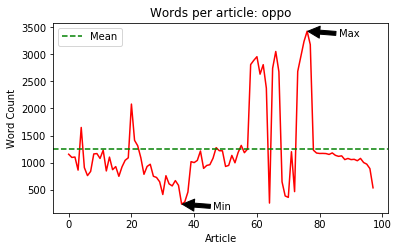

In [21]:
from pylab import * 
plt.figure(5,figsize=(6,3.5))
xlabel('Article') 
ylabel('Word Count')
title('Words per article: oppo')    
ion() 
plt.plot(num_pals_opo, "r")
axhline(mean(num_pals_opo), color='g',linestyle="--", label='Mean')
legend(loc='upper left')
annotate('Min', xy=(num_pals_opo.argmin(), num_pals_opo.min()), xytext=(num_pals_opo.argmin() + 10, num_pals_opo.min() - 100),
            arrowprops=dict(facecolor='black', shrink=0.02))
annotate('Max', xy=(num_pals_opo.argmax(), num_pals_opo.max()), xytext=(num_pals_opo.argmax() + 10, num_pals_opo.max() - 100),
            arrowprops=dict(facecolor='black', shrink=0.02))
savefig("pal_opo_2.eps", dpi=1500)
show()

### Número de palabras (oficialista)

In [22]:
data_ofi.head()

,Filename,Segment,WC,WPS,Sixltr,Dic,Funct,TotPron,PronPer,Yo,Nosotro,TuUtd,ElElla,Ellos,PronImp,Articulo,Verbos,VerbAux,Pasado,Present,Futuro,Adverb,Prepos,Conjunc,Negacio,Cuantif,Numeros,Maldec,verbYO,verbTU,verbNOS,verbosEL,verbELLOS,Subjuntiv,VosUtds,formal,informal,verbVos,Social,Familia,...,Tentat,Certeza,Inhib,Incl,Excl,Percept,Ver,Oir,Sentir,Biolog,Cuerpo,Salud,Sexual,Ingerir,Relativ,Movim,Espacio,Tiempo,Trabajo,Logro,Placer,Hogar,Dinero,Relig,Muerte,Asentir,NoFluen,Relleno,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,jf01.txt,1,1027,13.34,17.43,75.17,49.46,17.33,11.98,3.60,0.10,2.14,5.94,1.56,5.36,8.57,12.56,0.58,1.95,9.54,0.00,5.06,15.29,6.04,2.24,1.85,1.17,0.10,3.60,0.10,0.10,2.43,0.78,1.46,0.39,0.0,1.95,0.0,10.71,0.10,...,2.63,1.36,0.19,6.23,2.92,4.58,0.88,1.85,1.46,1.27,0.39,0.10,0.29,0.78,8.28,1.75,4.58,2.73,2.53,1.85,1.66,0.29,0.29,0.10,0.00,0.39,0.10,0.0,13.92,7.01,3.60,1.46,0.19,0.29,0.10,0.19,0.00,0.00,0.97,0.10
1,jf012.txt,1,4021,13.96,20.82,73.24,46.70,14.55,8.41,0.17,0.37,0.50,7.88,2.81,6.14,11.96,9.92,0.65,2.09,6.59,0.05,3.68,13.53,5.35,2.39,1.77,1.79,0.32,1.04,0.02,0.45,3.33,0.87,1.29,0.45,0.0,0.07,0.0,10.42,0.55,...,2.34,1.34,0.52,5.47,2.11,2.61,0.47,1.19,0.40,1.37,0.57,0.20,0.37,0.57,8.28,1.87,4.03,3.16,2.16,1.49,1.17,0.47,0.50,0.25,0.12,0.30,0.12,0.0,15.20,7.36,5.35,0.80,0.00,0.45,0.12,0.07,0.00,0.00,1.04,0.00
2,jf02.txt,1,4021,13.96,20.82,73.22,46.68,14.52,8.41,0.17,0.37,0.50,7.88,2.81,6.12,11.96,9.92,0.65,2.09,6.59,0.05,3.68,13.53,5.35,2.39,1.77,1.79,0.32,1.04,0.02,0.45,3.33,0.87,1.29,0.45,0.0,0.07,0.0,10.42,0.55,...,2.34,1.34,0.52,5.47,2.11,2.61,0.47,1.19,0.40,1.37,0.57,0.20,0.37,0.57,8.28,1.87,4.03,3.16,2.16,1.49,1.17,0.47,0.50,0.25,0.12,0.30,0.12,0.0,15.20,7.36,5.35,0.80,0.00,0.45,0.12,0.07,0.00,0.00,1.04,0.00
3,jf03.txt,1,3928,23.24,17.39,73.96,46.49,15.27,9.06,1.04,0.10,1.37,7.05,1.88,6.21,11.07,11.43,0.76,1.93,8.35,0.00,4.33,12.58,5.93,1.99,1.81,1.60,0.28,1.73,0.13,0.20,4.43,0.59,1.37,0.18,0.0,0.79,0.0,10.01,0.38,...,2.90,1.40,0.64,5.47,2.19,3.36,0.46,1.35,0.94,1.27,0.51,0.25,0.20,0.56,7.54,1.76,3.72,2.57,1.99,1.71,0.61,0.13,0.56,0.15,0.36,0.66,0.18,0.0,14.99,4.48,7.76,0.51,0.13,0.64,0.15,0.03,0.00,0.00,1.27,0.03
4,jf04.txt,1,891,27.00,17.06,80.02,45.79,16.05,8.08,0.79,0.34,0.45,7.07,2.58,7.97,9.65,12.91,1.01,0.90,10.77,0.00,5.39,11.22,6.06,2.81,1.57,3.03,0.00,1.57,0.00,0.56,5.61,0.90,1.46,0.34,0.0,0.00,0.0,13.02,1.23,...,3.37,1.57,0.00,4.15,1.80,2.58,1.46,0.56,0.22,1.01,0.11,0.22,0.34,0.45,6.40,2.24,3.59,2.02,1.23,0.90,0.22,0.11,1.12,0.00,0.00,0.00,0.11,0.0,19.53,6.29,7.97,0.67,0.00,0.45,0.11,0.00,3.37,0.22,0.45,0.00


In [23]:
num_pals_ofi = np.array(data_ofi['WC'])
print(num_pals_ofi)

[ 1027  4021  4021  3928   891   199  1399  1326  1549   881  1915  4784
   425  3380   626  4852  1647  1009  7150  1686   523   874   420   483
   348   900   764   538   845   480   368   995   372   946   828   876
   321   820   318   336   343   334   411   762   857   431   707   184
   580  3459   689   592   184   374   644   653   594   977  1416   707
   834  1623  1376   660  1112  1293  1126  1102   708  1305  1298  1331
  1224  1061  4613  1216 34676 36619   358   923   274   139   511   166
   227   615   335   432   325   429   236   364  2605   552  2993  3483
   364   311]


In [24]:
print("num_pal_ofi: Mean: ", num_pals_ofi.mean())
print("num_pal_ofi: standard deviation:", num_pals_ofi.std())
print("num_pal_ofi minimo: ", num_pals_ofi.min())
print("num_pal_ofi: maximo: ", num_pals_ofi.max())

num_pal_ofi: Mean:  1865.1836734693877
num_pal_ofi: standard deviation: 5031.564637461983
num_pal_ofi minimo:  139
num_pal_ofi: maximo:  36619


In [25]:
print("25th percentile: ", np.percentile(num_pals_ofi, 25))
print("Median: ", np.median(num_pals_ofi))
print("75th percentile: ", np.percentile(num_pals_ofi, 75))

25th percentile:  421.25
Median:  792.0
75th percentile:  1303.25


In [26]:
num_pals_ofi.argmin()

81

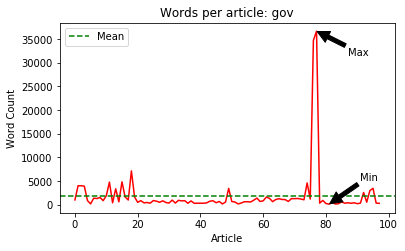

In [27]:
from pylab import * 
plt.figure(5,figsize=(6,3.5))
xlabel('Article') 
ylabel('Word Count')
title('Words per article: gov')    
ion() 
plt.plot(num_pals_ofi, "r")
axhline(mean(num_pals_ofi), color='g',linestyle="--", label='Mean')
legend(loc='upper left')
annotate('Min', xy=(num_pals_ofi.argmin(), num_pals_ofi.min()), xytext=(num_pals_ofi.argmin() + 10, num_pals_ofi.min() + 5000),
            arrowprops=dict(facecolor='black', shrink=0.02))
annotate('Max', xy=(num_pals_ofi.argmax(), num_pals_ofi.max()), xytext=(num_pals_ofi.argmax() + 10, num_pals_ofi.max() - 5000),
            arrowprops=dict(facecolor='black', shrink=0.02))
savefig("pal_ofic_2.eps", dpi=1500)
show()

### Número de palabras (oficialista + opositor)

In [28]:
data_ofi_opo.head()

,Filename,Segment,WC,WPS,Sixltr,Dic,Funct,TotPron,PronPer,Yo,Nosotro,TuUtd,ElElla,Ellos,PronImp,Articulo,Verbos,VerbAux,Pasado,Present,Futuro,Adverb,Prepos,Conjunc,Negacio,Cuantif,Numeros,Maldec,verbYO,verbTU,verbNOS,verbosEL,verbELLOS,Subjuntiv,VosUtds,formal,informal,verbVos,Social,Familia,...,Tentat,Certeza,Inhib,Incl,Excl,Percept,Ver,Oir,Sentir,Biolog,Cuerpo,Salud,Sexual,Ingerir,Relativ,Movim,Espacio,Tiempo,Trabajo,Logro,Placer,Hogar,Dinero,Relig,Muerte,Asentir,NoFluen,Relleno,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,jf01.txt,1,1027,13.34,17.43,75.17,49.46,17.33,11.98,3.60,0.10,2.14,5.94,1.56,5.36,8.57,12.56,0.58,1.95,9.54,0.00,5.06,15.29,6.04,2.24,1.85,1.17,0.10,3.60,0.10,0.10,2.43,0.78,1.46,0.39,0.0,1.95,0.0,10.71,0.10,...,2.63,1.36,0.19,6.23,2.92,4.58,0.88,1.85,1.46,1.27,0.39,0.10,0.29,0.78,8.28,1.75,4.58,2.73,2.53,1.85,1.66,0.29,0.29,0.10,0.00,0.39,0.10,0.0,13.92,7.01,3.60,1.46,0.19,0.29,0.10,0.19,0.00,0.00,0.97,0.10
1,jf012.txt,1,4021,13.96,20.82,73.24,46.70,14.55,8.41,0.17,0.37,0.50,7.88,2.81,6.14,11.96,9.92,0.65,2.09,6.59,0.05,3.68,13.53,5.35,2.39,1.77,1.79,0.32,1.04,0.02,0.45,3.33,0.87,1.29,0.45,0.0,0.07,0.0,10.42,0.55,...,2.34,1.34,0.52,5.47,2.11,2.61,0.47,1.19,0.40,1.37,0.57,0.20,0.37,0.57,8.28,1.87,4.03,3.16,2.16,1.49,1.17,0.47,0.50,0.25,0.12,0.30,0.12,0.0,15.20,7.36,5.35,0.80,0.00,0.45,0.12,0.07,0.00,0.00,1.04,0.00
2,jf02.txt,1,4021,13.96,20.82,73.22,46.68,14.52,8.41,0.17,0.37,0.50,7.88,2.81,6.12,11.96,9.92,0.65,2.09,6.59,0.05,3.68,13.53,5.35,2.39,1.77,1.79,0.32,1.04,0.02,0.45,3.33,0.87,1.29,0.45,0.0,0.07,0.0,10.42,0.55,...,2.34,1.34,0.52,5.47,2.11,2.61,0.47,1.19,0.40,1.37,0.57,0.20,0.37,0.57,8.28,1.87,4.03,3.16,2.16,1.49,1.17,0.47,0.50,0.25,0.12,0.30,0.12,0.0,15.20,7.36,5.35,0.80,0.00,0.45,0.12,0.07,0.00,0.00,1.04,0.00
3,jf03.txt,1,3928,23.24,17.39,73.96,46.49,15.27,9.06,1.04,0.10,1.37,7.05,1.88,6.21,11.07,11.43,0.76,1.93,8.35,0.00,4.33,12.58,5.93,1.99,1.81,1.60,0.28,1.73,0.13,0.20,4.43,0.59,1.37,0.18,0.0,0.79,0.0,10.01,0.38,...,2.90,1.40,0.64,5.47,2.19,3.36,0.46,1.35,0.94,1.27,0.51,0.25,0.20,0.56,7.54,1.76,3.72,2.57,1.99,1.71,0.61,0.13,0.56,0.15,0.36,0.66,0.18,0.0,14.99,4.48,7.76,0.51,0.13,0.64,0.15,0.03,0.00,0.00,1.27,0.03
4,jf04.txt,1,891,27.00,17.06,80.02,45.79,16.05,8.08,0.79,0.34,0.45,7.07,2.58,7.97,9.65,12.91,1.01,0.90,10.77,0.00,5.39,11.22,6.06,2.81,1.57,3.03,0.00,1.57,0.00,0.56,5.61,0.90,1.46,0.34,0.0,0.00,0.0,13.02,1.23,...,3.37,1.57,0.00,4.15,1.80,2.58,1.46,0.56,0.22,1.01,0.11,0.22,0.34,0.45,6.40,2.24,3.59,2.02,1.23,0.90,0.22,0.11,1.12,0.00,0.00,0.00,0.11,0.0,19.53,6.29,7.97,0.67,0.00,0.45,0.11,0.00,3.37,0.22,0.45,0.00


In [29]:
num_pals_ofi_opo = np.array(data_ofi_opo['WC'])
print(num_pals_ofi_opo)

[ 1027  4021  4021  3928   891   199  1399  1326  1549   881  1915  4784
   425  3380   626  4852  1647  1009  7150  1686   523   874   420   483
   348   900   764   538   845   480   368   995   372   946   828   876
   321   820   318   336   343   334   411   762   857   431   707   184
   580  3459   689   592   184   374   644   653   594   977  1416   707
   834  1623  1376   660  1112  1293  1126  1102   708  1305  1298  1331
  1224  1061  4613  1216 34676 36619   358   923   274   139   511   166
   227   615   335   432   325   429   236   364  2605   552  2993  3483
   364   311  1156  1097  1104   863  1649   909   762   839  1161  1168
  1078  1230   848  1103   871   928   749   923  1044  1090  2080  1412
  1312  1091   786   931   971   750   728   648   414   760   610   572
   670   583   236   278   459  1019  1002  1042  1215   895   949   963
  1081  1277  1221  1219   931   950  1134   998  1187  1318  1184  1251
  2808  2886  2953  2631  2806  2374   256  2739  3

In [30]:
print("num_pal_ofi_opo: Mean: ", num_pals_ofi_opo.mean())
print("num_pal_ofi_opo: standard deviation:", num_pals_ofi_opo.std())
print("num_pal_ofi_opo minimo: ", num_pals_ofi_opo.min())
print("num_pal_ofi_opo: maximo: ", num_pals_ofi_opo.max())

num_pal_ofi_opo: Mean:  1554.0969387755101
num_pal_ofi_opo: standard deviation: 3608.914572785576
num_pal_ofi_opo minimo:  139
num_pal_ofi_opo: maximo:  36619


In [31]:
print("25th percentile: ", np.percentile(num_pals_ofi_opo, 25))
print("Median: ", np.median(num_pals_ofi_opo))
print("75th percentile: ", np.percentile(num_pals_ofi_opo, 75))

25th percentile:  606.0
Median:  975.0
75th percentile:  1230.0


In [32]:
num_pals_ofi_opo.argmin()

81

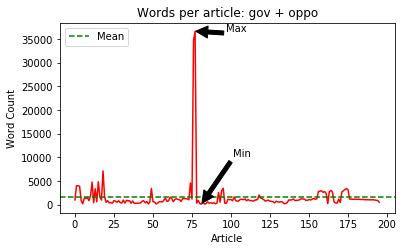

In [33]:
from pylab import * 
plt.figure(5,figsize=(6,3.5))
xlabel('Article') 
ylabel('Word Count')
title('Words per article: gov + oppo')    
ion() 
plt.plot(num_pals_ofi_opo, "r")
axhline(mean(num_pals_ofi_opo), color='g',linestyle="--", label='Mean')
legend(loc='upper left')
annotate('Min', xy=(num_pals_ofi_opo.argmin(), num_pals_ofi_opo.min()), xytext=(num_pals_ofi_opo.argmin() + 20, num_pals_ofi_opo.min() + 10000),
            arrowprops=dict(facecolor='black', shrink=0.02))
annotate('Max', xy=(num_pals_ofi_opo.argmax(), num_pals_ofi_opo.max()), xytext=(num_pals_ofi_opo.argmax() + 20, num_pals_ofi_opo.max()),
            arrowprops=dict(facecolor='black', shrink=0.02))
plt.savefig("pal_ofi_opo_2.eps", dpi=1500)
show()

### 2.2) Features dinámicas (BoW)

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir("/content/gdrive/My Drive")

In [36]:
from sklearn.datasets import load_files

articulos_corpus = load_files("textos_ofi_opo_UTF",encoding='utf-8')
# load_files returns a bunch, containing training texts and training labels
text_artic, clase_artic = articulos_corpus.data, articulos_corpus.target
print("type de lo que devuelve load_files: {}".format(type(articulos_corpus)))
print("type of text_artic: {}".format(type(text_artic)))
print("type of clase_artic: {}".format(type(text_artic)))
print("length of text_artic: {}".format(len(text_artic)))
print("text_artic[0]:\n{}".format(text_artic[0]))


type de lo que devuelve load_files: <class 'sklearn.utils.Bunch'>
type of text_artic: <class 'list'>
type of clase_artic: <class 'list'>
length of text_artic: 196
text_artic[0]:
El anuncio de la Presidenta no es un fatalismo
Llega un momento en el que hay que tomar decisiones. Ojalá que mucha gente siga el mismo camino que tomo. El mensaje de la Presidenta dice que el dólar no vale lo que están diciendo.
Una sociedad que no puede comprar dólares me duele menos que ver cómo en los ‘90 tantas personas se quedaban sin trabajo.
Tengo un repudio a los cacerolazos, estamos en un año donde hay medios de comunicación que están dispuestos a que el país se incendie, porque piensan que van a poder salir ganando.
Siempre supe que perdía dinero comprando dólares, pero fui un desconocedor; era una cuestión cultural.
El dólar siempre significó una pequeña seguridad para la clase media y quizá sigue siéndolo, pero si no se hubiese presentado esta coyuntura.
El anuncio de la Presidenta no es un fatalis

In [37]:
num_pals = 0
for str in text_artic:
    num_pals = num_pals + len(str.split())
print('Número de palabras en el Data Set Original')
print(num_pals)

Número de palabras en el Data Set Original
281073


In [0]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    #text = text.lower()
    text = re.sub('\r\n', ' ', text)
    text = re.sub('\ufeff', ' ', text)
    #text = re.sub('\[.*?\]', ' ', text)
    #text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    return text

In [0]:
text_artic = [clean_text(doc) for doc in text_artic]

In [40]:
num_pals = 0
for str in text_artic:
    num_pals = num_pals + len(str.split())
print(num_pals)

280343


In [41]:
vect = CountVectorizer().fit(text_artic) # Esto ya lo había hecho antes en dos pasos
X_train = vect.transform(text_artic)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<196x24323 sparse matrix of type '<class 'numpy.int64'>'
	with 99998 stored elements in Compressed Sparse Row format>


In [42]:
# Esto también ya lo había hecho
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 24323
First 20 features:
['aa', 'aaa', 'aanto', 'abaca', 'abajo', 'abal', 'abalanzan', 'abandona', 'abandonaba', 'abandonaban', 'abandonado', 'abandonados', 'abandonar', 'abandonara', 'abandonarlo', 'abandonaron', 'abandonará', 'abandono', 'abandonó', 'abanico']
Features 20010 to 20030:
['republica', 'republicana', 'republicanas', 'republicano', 'republicanos', 'repudiable', 'repudiada', 'repudiemos', 'repudio', 'repudios', 'repudió', 'repuesta', 'repugnancia', 'repugnante', 'repugne', 'repulsa', 'repulsivos', 'repunte', 'repuso', 'reputación']
Every 2000th feature:
['aa', 'arrollada', 'cesan', 'cuarto', 'docentes', 'expliquemos', 'hábilmente', 'licencia', 'novelas', 'posta', 'reproducción', 'sujeto', 'volantazo']


#### Ahora hago una vectorización de los documentos, con una frecuencia mínima de 5 documentos, y luego elimino las palabras de paro

In [43]:
vect = CountVectorizer(min_df=5).fit(text_artic)
X_train = vect.transform(text_artic)
print("X_train with min_df: {}".format(repr(X_train)))



X_train with min_df: <196x4155 sparse matrix of type '<class 'numpy.int64'>'
	with 68383 stored elements in Compressed Sparse Row format>


In [44]:
feature_names = vect.get_feature_names()

print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 1510 to 1530:\n{}".format(feature_names[1510:1530]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

First 50 features:
['abajo', 'abal', 'abandonar', 'abarca', 'abierta', 'abiertas', 'abierto', 'abiertos', 'abogada', 'abogado', 'abogados', 'aborto', 'abrazo', 'abre', 'abrieron', 'abril', 'abrir', 'abrió', 'abría', 'absoluta', 'absolutamente', 'absurda', 'absurdo', 'abuelas', 'abunda', 'abuso', 'acaba', 'acabó', 'acaso', 'acceder', 'acceso', 'accionar', 'acciones', 'acción', 'acepción', 'acepta', 'aceptación', 'aceptan', 'aceptar', 'aceptaron', 'aceptó', 'acerca', 'acercamiento', 'aclara', 'aclarar', 'aclaró', 'acompañada', 'acompañan', 'acompañó', 'acontecimiento']
Features 1510 to 1530:
['excelente', 'excepcional', 'excepciones', 'excepción', 'exceso', 'exclusión', 'excusa', 'exhibe', 'exhibir', 'exige', 'exista', 'existe', 'existen', 'existencia', 'existir', 'existió', 'existía', 'existían', 'expectativas', 'expediente']
Every 700th feature:
['abajo', 'condenado', 'escritorio', 'jornada', 'parecida', 'salvar']


### Stop-words (en español, de NLTK)

In [45]:
import nltk
nltk.download('stopwords')

# We are going to create a document-term matrix using CountVectorizer, and exclude common Spanish stop words
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('spanish')) 

print("Number of stop words: {}".format(len(stop_words)))
print("Number of stop words: {}".format(stop_words))
print("Every 10th stopword:\n{}".format(list(stop_words)[::10]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Number of stop words: 313
Number of stop words: {'antes', 'nuestras', 'estaréis', 'te', 'tengan', 'sí', 'también', 'tengáis', 'mías', 'habrás', 'estuve', 'estando', 'habíamos', 'sentidas', 'hubieron', 'nuestro', 'sean', 'tienes', 'suyos', 'soy', 'tengas', 'somos', 'estará', 'hubieran', 'seréis', 'tengo', 'tienen', 'hubieses', 'mía', 'hayamos', 'contra', 'habéis', 'tenéis', 'había', 'os', 'estarán', 'habríamos', 'fuera', 'estuviesen', 'fue', 'tengamos', 'teníamos', 'ella', 'estuviste', 'estados', 'estoy', 'en', 'seríais', 'tenía', 'hubieras', 'fuésemos', 'o', 'tenemos', 'estamos', 'le', 'tendríamos', 'estar', 'estuviéramos', 'estemos', 'seremos', 'tuvieses', 'vosotros', 'esos', 'nuestra', 'los', 'estada', 'tenían', 'éramos', 'serán', 'estuvieran', 'ante', 'siente', 'fueseis', 'tuviésemos', 'al', 'tus', 'estabais', 'hubiesen', 'estarías', 'has', 'habré', 'hubierais', 'fueras', '

#### Ahora vectorizo sin las palabras de paro

In [46]:
vect = CountVectorizer(min_df=5,stop_words=stop_words).fit(text_artic)
X_train = vect.transform(text_artic)
print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <196x3981 sparse matrix of type '<class 'numpy.int64'>'
	with 55044 stored elements in Compressed Sparse Row format>


#### y lo mismo puedo hacer con otros vectorizadores

In [47]:
vect = TfidfVectorizer(min_df=5,stop_words=stop_words).fit(text_artic)
X_train = vect.transform(text_artic)
print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <196x3981 sparse matrix of type '<class 'numpy.float64'>'
	with 55044 stored elements in Compressed Sparse Row format>


#3) Críticas de películas (desde NLTK)

In [48]:
import nltk
import random
# nltk.download('punkt')
nltk.download('movie_reviews')
from nltk.corpus import movie_reviews




[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


In [0]:
opiniones = [' '.join(movie_reviews.words(fileid))
                for category in movie_reviews.categories()
                for fileid in movie_reviews.fileids(category)]
categoria = [ int(category == 'pos')
                for category in movie_reviews.categories()
                for fileid in movie_reviews.fileids(category)]



In [50]:
print("Tipo y tamaño de las opiniones \n", type(opiniones),len(opiniones))
print("Tipo de cada opinión \n", type(opiniones[0]))

Tipo y tamaño de las opiniones 
 <class 'list'> 2000
Tipo de cada opinión 
 <class 'str'>


In [51]:
print("Ejemplo: la primera opinión: \n")
print(opiniones[0])

Ejemplo: la primera opinión: 

plot : two teen couples go to a church party , drink and then drive . they get into an accident . one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . what ' s the deal ? watch the movie and " sorta " find out . . . critique : a mind - fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn ' t snag this one correctly . they seem to have taken this pretty neat concept , but executed it terribly . so what are the problems with the movie ? well , its main problem is that it ' s simply too jumbled . it starts off " normal " but then downshifts into this " fantasy " world in which you , as an

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect_opi = CountVectorizer().fit(opiniones)
X3 = vect_opi.transform(opiniones)

print("Tipo de los datos vectorizados (Matriz X3): ", type(X3))
print("Tipo del arreglo target (vector categoria): ", type(categoria))
print("... y los tamaños de X3 y categoria")
print(X3.shape)
print(len(categoria))


Tipo de los datos vectorizados (Matriz X3):  <class 'scipy.sparse.csr.csr_matrix'>
Tipo del arreglo target (vector categoria):  <class 'list'>
... y los tamaños de X3 y categoria
(2000, 39659)
2000


In [0]:
feature_names = vect_opi.get_feature_names()

In [54]:
print("numero de features: {}".format(len(feature_names)))

numero de features: 39659


In [55]:
print("Primeras 20 features: {}".format(feature_names[:20]))

Primeras 20 features: ['00', '000', '0009f', '007', '00s', '03', '04', '05', '05425', '10', '100', '1000', '10000', '100m', '101', '102', '103', '104', '105', '106']


In [56]:
print("Features 20010 a 20030: {}".format(feature_names[20010:20030]))

Features 20010 a 20030: ['lathered', 'latifa', 'latifah', 'latin', 'latit', 'latitude', 'latrobe', 'latter', 'lattitude', 'latura', 'lau', 'laudable', 'laude', 'lauded', 'laudible', 'laugh', 'laughable', 'laughably', 'laughed', 'laugher']


In [57]:
print("Cada 1000 features: {}".format(feature_names[::1000]))

Cada 1000 features: ['00', 'ad2am', 'anvil', 'baileys', 'blanc', 'bulb', 'chao', 'comatose', 'counterprogramming', 'declining', 'discussion', 'dysart', 'eschew', 'femke', 'fresh', 'gonzo', 'hateful', 'huison', 'inhospitable', 'jolie', 'laszlo', 'lucus', 'meatloaf', 'mortgages', 'norma', 'overpaid', 'pfeiffer', 'prefacing', 'racial', 'renny', 'roughly', 'secret', 'sisters', 'spices', 'stylize', 'teases', 'traditional', 'unethical', 'vineyard', 'wish']


#4) Transcripción de monólogos (bajados de la Web)

In [0]:
# Web scraping, pickle imports
import requests
from bs4 import BeautifulSoup
import pickle

# Scrapes transcript data from scrapsfromtheloft.com
def url_to_transcript(url):
    '''Returns transcript data specifically from scrapsfromtheloft.com.'''
    page = requests.get(url).text
    soup = BeautifulSoup(page, "lxml")
    text = [p.text for p in soup.find(class_="post-content").find_all('p')]
    print(url)
    return text

# URLs of transcripts in scope
urls = ['http://scrapsfromtheloft.com/2017/05/06/louis-ck-oh-my-god-full-transcript/',
        'http://scrapsfromtheloft.com/2017/04/11/dave-chappelle-age-spin-2017-full-transcript/',
        'http://scrapsfromtheloft.com/2018/03/15/ricky-gervais-humanity-transcript/',
        'http://scrapsfromtheloft.com/2017/08/07/bo-burnham-2013-full-transcript/',
        'http://scrapsfromtheloft.com/2017/05/24/bill-burr-im-sorry-feel-way-2014-full-transcript/',
        'http://scrapsfromtheloft.com/2017/04/21/jim-jefferies-bare-2014-full-transcript/',
        'http://scrapsfromtheloft.com/2017/08/02/john-mulaney-comeback-kid-2015-full-transcript/',
        'http://scrapsfromtheloft.com/2017/10/21/hasan-minhaj-homecoming-king-2017-full-transcript/',
        'http://scrapsfromtheloft.com/2017/09/19/ali-wong-baby-cobra-2016-full-transcript/',
        'http://scrapsfromtheloft.com/2017/08/03/anthony-jeselnik-thoughts-prayers-2015-full-transcript/',
        'http://scrapsfromtheloft.com/2018/03/03/mike-birbiglia-my-girlfriends-boyfriend-2013-full-transcript/',
        'http://scrapsfromtheloft.com/2017/08/19/joe-rogan-triggered-2016-full-transcript/']

# Comedian names
comedians = ['louis', 'dave', 'ricky', 'bo', 'bill', 'jim', 'john', 'hasan', 'ali', 'anthony', 'mike', 'joe']

In [59]:
# # Actually request transcripts (takes a few minutes to run)
transcripts = [url_to_transcript(u) for u in urls]

http://scrapsfromtheloft.com/2017/05/06/louis-ck-oh-my-god-full-transcript/
http://scrapsfromtheloft.com/2017/04/11/dave-chappelle-age-spin-2017-full-transcript/
http://scrapsfromtheloft.com/2018/03/15/ricky-gervais-humanity-transcript/
http://scrapsfromtheloft.com/2017/08/07/bo-burnham-2013-full-transcript/
http://scrapsfromtheloft.com/2017/05/24/bill-burr-im-sorry-feel-way-2014-full-transcript/
http://scrapsfromtheloft.com/2017/04/21/jim-jefferies-bare-2014-full-transcript/
http://scrapsfromtheloft.com/2017/08/02/john-mulaney-comeback-kid-2015-full-transcript/
http://scrapsfromtheloft.com/2017/10/21/hasan-minhaj-homecoming-king-2017-full-transcript/
http://scrapsfromtheloft.com/2017/09/19/ali-wong-baby-cobra-2016-full-transcript/
http://scrapsfromtheloft.com/2017/08/03/anthony-jeselnik-thoughts-prayers-2015-full-transcript/
http://scrapsfromtheloft.com/2018/03/03/mike-birbiglia-my-girlfriends-boyfriend-2013-full-transcript/
http://scrapsfromtheloft.com/2017/08/19/joe-rogan-triggered-

In [60]:
print(type(transcripts))
print(type(transcripts[0]))
artista = transcripts[0]
print(artista)
print(artista[0])

<class 'list'>
<class 'list'>
['Intro\nFade the music out. Let’s roll. Hold there. Lights. Do the lights. Thank you. Thank you very much. I appreciate that. I don’t necessarily agree with you, but I appreciate very much. Well, this is a nice place. This is easily the nicest place For many miles in every direction. That’s how you compliment a building And shit on a town with one sentence. It is odd around here, as I was driving here. There doesn’t seem to be any difference Between the sidewalk and the street for pedestrians here. People just kind of walk in the middle of the road. I love traveling And seeing all the different parts of the country. I live in New York. I live in a– There’s no value to your doing that at all.', '“The Old Lady And The Dog”\nI live– I live in New York. I always– Like, there’s this old lady in my neighborhood, And she’s always walking her dog. She’s always just– she’s very old. She just stands there just being old, And the dog just fights gravity every day, j

In [61]:
# Cargar los textos en un diccionario
data = {}
for i, c in enumerate(comedians):
    print(i)
    print(c)
    data[c] = transcripts[i]

0
louis
1
dave
2
ricky
3
bo
4
bill
5
jim
6
john
7
hasan
8
ali
9
anthony
10
mike
11
joe


In [62]:
# Double check to make sure data has been loaded properly
print(type(data))
data.keys()
print(type(data['louis']))
print(type(data['louis'][0]))

<class 'dict'>
<class 'list'>
<class 'str'>


In [63]:
# More checks
data['louis'][:2]

['Intro\nFade the music out. Let’s roll. Hold there. Lights. Do the lights. Thank you. Thank you very much. I appreciate that. I don’t necessarily agree with you, but I appreciate very much. Well, this is a nice place. This is easily the nicest place For many miles in every direction. That’s how you compliment a building And shit on a town with one sentence. It is odd around here, as I was driving here. There doesn’t seem to be any difference Between the sidewalk and the street for pedestrians here. People just kind of walk in the middle of the road. I love traveling And seeing all the different parts of the country. I live in New York. I live in a– There’s no value to your doing that at all.',
 '“The Old Lady And The Dog”\nI live– I live in New York. I always– Like, there’s this old lady in my neighborhood, And she’s always walking her dog. She’s always just– she’s very old. She just stands there just being old, And the dog just fights gravity every day, just– The two of them, it’s re

#5) Archivo arbitario local (Subido con upload)

## Asumamos que se subirá el mismo archivo csv donde se guarda la representación LIWC de la colección oficialistas - opositores

In [65]:
from google.colab import files
 
files.upload()  

Saving ofi_opo_LIWC.csv to ofi_opo_LIWC (3).csv


{'ofi_opo_LIWC.csv': b'Filename,Segment,WC,WPS,Sixltr,Dic,Funct,TotPron,PronPer,Yo,Nosotro,TuUtd,ElElla,Ellos,PronImp,Articulo,Verbos,VerbAux,Pasado,Present,Futuro,Adverb,Prepos,Conjunc,Negacio,Cuantif,Numeros,Maldec,verbYO,verbTU,verbNOS,verbosEL,verbELLOS,Subjuntiv,VosUtds,formal,informal,verbVos,Social,Familia,Amigos,Humanos,Afect,EmoPos,EmoNeg,Ansiedad,Enfado,Triste,MecCog,Insight,Causa,Discrep,Tentat,Certeza,Inhib,Incl,Excl,Percept,Ver,Oir,Sentir,Biolog,Cuerpo,Salud,Sexual,Ingerir,Relativ,Movim,Espacio,Tiempo,Trabajo,Logro,Placer,Hogar,Dinero,Relig,Muerte,Asentir,NoFluen,Relleno,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP\r\njf01.txt,1,1027,"13,34","17,43","75,17","49,46","17,33","11,98","3,60","0,10","2,14","5,94","1,56","5,36","8,57","12,56","0,58","1,95","9,54","0,00","5,06","15,29","6,04","2,24","1,85","1,17","0,10","3,60","0,10","0,10","2,43","0,78","1,46","0,39","0,00","1,95","0,00","10,71","0,10","0,49","0,49","3,02","2,14","0,97","0,10",

In [0]:
import pandas as pd 
df = pd.read_csv('ofi_opo_LIWC.csv')

In [67]:
df.head()

,Filename,Segment,WC,WPS,Sixltr,Dic,Funct,TotPron,PronPer,Yo,Nosotro,TuUtd,ElElla,Ellos,PronImp,Articulo,Verbos,VerbAux,Pasado,Present,Futuro,Adverb,Prepos,Conjunc,Negacio,Cuantif,Numeros,Maldec,verbYO,verbTU,verbNOS,verbosEL,verbELLOS,Subjuntiv,VosUtds,formal,informal,verbVos,Social,Familia,...,Tentat,Certeza,Inhib,Incl,Excl,Percept,Ver,Oir,Sentir,Biolog,Cuerpo,Salud,Sexual,Ingerir,Relativ,Movim,Espacio,Tiempo,Trabajo,Logro,Placer,Hogar,Dinero,Relig,Muerte,Asentir,NoFluen,Relleno,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,jf01.txt,1,1027,"13,34","17,43","75,17","49,46","17,33","11,98","3,60","0,10","2,14","5,94","1,56","5,36","8,57","12,56","0,58","1,95","9,54","0,00","5,06","15,29","6,04","2,24","1,85","1,17","0,10","3,60","0,10","0,10","2,43","0,78","1,46","0,39","0,00","1,95","0,00","10,71","0,10",...,"2,63","1,36","0,19","6,23","2,92","4,58","0,88","1,85","1,46","1,27","0,39","0,10","0,29","0,78","8,28","1,75","4,58","2,73","2,53","1,85","1,66","0,29","0,29","0,10","0,00","0,39","0,10","0,00","13,92","7,01","3,60","1,46","0,19","0,29","0,10","0,19","0,00","0,00","0,97","0,10"
1,jf012.txt,1,4021,"13,96","20,82","73,24","46,70","14,55","8,41","0,17","0,37","0,50","7,88","2,81","6,14","11,96","9,92","0,65","2,09","6,59","0,05","3,68","13,53","5,35","2,39","1,77","1,79","0,32","1,04","0,02","0,45","3,33","0,87","1,29","0,45","0,00","0,07","0,00","10,42","0,55",...,"2,34","1,34","0,52","5,47","2,11","2,61","0,47","1,19","0,40","1,37","0,57","0,20","0,37","0,57","8,28","1,87","4,03","3,16","2,16","1,49","1,17","0,47","0,50","0,25","0,12","0,30","0,12","0,00","15,20","7,36","5,35","0,80","0,00","0,45","0,12","0,07","0,00","0,00","1,04","0,00"
2,jf02.txt,1,4021,"13,96","20,82","73,22","46,68","14,52","8,41","0,17","0,37","0,50","7,88","2,81","6,12","11,96","9,92","0,65","2,09","6,59","0,05","3,68","13,53","5,35","2,39","1,77","1,79","0,32","1,04","0,02","0,45","3,33","0,87","1,29","0,45","0,00","0,07","0,00","10,42","0,55",...,"2,34","1,34","0,52","5,47","2,11","2,61","0,47","1,19","0,40","1,37","0,57","0,20","0,37","0,57","8,28","1,87","4,03","3,16","2,16","1,49","1,17","0,47","0,50","0,25","0,12","0,30","0,12","0,00","15,20","7,36","5,35","0,80","0,00","0,45","0,12","0,07","0,00","0,00","1,04","0,00"
3,jf03.txt,1,3928,"23,24","17,39","73,96","46,49","15,27","9,06","1,04","0,10","1,37","7,05","1,88","6,21","11,07","11,43","0,76","1,93","8,35","0,00","4,33","12,58","5,93","1,99","1,81","1,60","0,28","1,73","0,13","0,20","4,43","0,59","1,37","0,18","0,00","0,79","0,00","10,01","0,38",...,"2,90","1,40","0,64","5,47","2,19","3,36","0,46","1,35","0,94","1,27","0,51","0,25","0,20","0,56","7,54","1,76","3,72","2,57","1,99","1,71","0,61","0,13","0,56","0,15","0,36","0,66","0,18","0,00","14,99","4,48","7,76","0,51","0,13","0,64","0,15","0,03","0,00","0,00","1,27","0,03"
4,jf04.txt,1,891,"27,00","17,06","80,02","45,79","16,05","8,08","0,79","0,34","0,45","7,07","2,58","7,97","9,65","12,91","1,01","0,90","10,77","0,00","5,39","11,22","6,06","2,81","1,57","3,03","0,00","1,57","0,00","0,56","5,61","0,90","1,46","0,34","0,00","0,00","0,00","13,02","1,23",...,"3,37","1,57","0,00","4,15","1,80","2,58","1,46","0,56","0,22","1,01","0,11","0,22","0,34","0,45","6,40","2,24","3,59","2,02","1,23","0,90","0,22","0,11","1,12","0,00","0,00","0,00","0,11","0,00","19,53","6,29","7,97","0,67","0,00","0,45","0,11","0,00","3,37","0,22","0,45","0,00"


También se pueden guardar archivos ...(lo baja automáticamente a "Descargas")

In [0]:
files.download('ofi_opo_LIWC.csv')